# IA – Projeto 02
## Association Rules – Perfis de Corridas em F1

**Unidade Curricular:** Inteligência Artificial  
**Ano Letivo:** 2025/2026  

### Discentes

- Carlos Sousa (24880)  
- Pedro Gonçalves (26018)  
- Carlos Moreda (26875)  

---

## 1. Introdução e Objetivos

Neste Notebook 03 vamos continuar a explorar os dados históricos de Fórmula 1 (utilizando o dataset **"Formula 1 Race Data (1950–2017)"** do Kaggle), mas agora com foco em Regras de Associação.

Dataset original: **[Formula 1 Race Data (Kaggle)](https://www.kaggle.com/datasets/cjgdev/formula-1-race-data-19502017)**

Neste notebook queremos descobrir padrões frequentes do tipo:

> “Partir na frente + equipa de topo = Alta probabilidade de terminar no pódio”  
> “Partir no fundo + equipa pequena = Quase sempre fora dos pontos”

Ou seja, vamos tentar identificar perfis de corridas em F1 a partir de combinações de características como:

- posição na grelha (`grid`),  
- posição final (`positionOrder`),  
- lugares ganhos/perdidos (`gained_positions`),  
- pontos,  
- década da corrida,  
- tipo de equipa (top team / outras),
- e se houve pódio ou não.

Posto isto neste notebook vamos:

1. Definir o objetivo de negócio;  
2. Preparar os dados para regras de associação;  
3. Aplicar o algoritmo **Apriori**;  
4. Gerar conjuntos frequentes de itens e respetivas **regras de associação**;  
5. Filtrar regras relevantes;
6. Interpretar alguns padrões interessantes no contexto de F1;


#### Imports e Configuração Inicial


In [57]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx


from sklearn.preprocessing import StandardScaler

from mlxtend.frequent_patterns import apriori, association_rules

sns.set(style="whitegrid")
%matplotlib inline

#### Carregamento dos ficheiros de F1

In [58]:
# Carregar ficheiro de resultados
results = pd.read_csv("results.csv")

# Carregar ficheiros de contexto
races = pd.read_csv("races.csv")                                                # informação da corrida (ano, circuito, data,etc)
drivers = pd.read_csv("drivers.csv", encoding="latin1")                         # info dos pilotos
constructors = pd.read_csv("constructors.csv", encoding="latin1")               # info das equipas
circuits = pd.read_csv("circuits.csv", encoding="latin1")                       # info dos circuitos
constructor_results = pd.read_csv("constructorResults.csv", encoding="latin1")  # info dos resultados das equipas

#### Junção de contexto e criação de variáveis base

In [59]:
# Adicionar ano, ronda e circuito
df = results.merge(
    races[["raceId", "year", "round", "circuitId"]],
    on="raceId",
    how="left"
)

# Adicionar país do circuito
df = df.merge(
    circuits[["circuitId", "country"]],
    on="circuitId",
    how="left"
)

# Adicionar nome e nacionalidade da equipa
df = df.merge(
    constructors[["constructorId", "name", "nationality"]],
    on="constructorId",
    how="left"
)

# Adicionar nome e nacionalidade do piloto
cr = constructor_results.merge(
    races[["raceId", "year"]],
    on="raceId",
    how="left"
)

# Adicoionar nome da equipa
cr = cr.merge(
    constructors[["constructorId", "name"]],
    on="constructorId",
    how="left",
    suffixes=("", "_constructor")
)

# Ver as primeiras linhas do dataset final
df.head()

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,...,rank,fastestLapTime,fastestLapSpeed,statusId,year,round,circuitId,country,name,nationality
0,1,18,1,1,22.0,1,1.0,1,1,10.0,...,2.0,01:27.5,218.3,1,2008,1,1,Australia,McLaren,British
1,2,18,2,2,3.0,5,2.0,2,2,8.0,...,3.0,01:27.7,217.586,1,2008,1,1,Australia,BMW Sauber,German
2,3,18,3,3,7.0,7,3.0,3,3,6.0,...,5.0,01:28.1,216.719,1,2008,1,1,Australia,Williams,British
3,4,18,4,4,5.0,11,4.0,4,4,5.0,...,7.0,01:28.6,215.464,1,2008,1,1,Australia,Renault,French
4,5,18,5,1,23.0,3,5.0,5,5,4.0,...,1.0,01:27.4,218.385,1,2008,1,1,Australia,McLaren,British


#### Limpeza mínima e variáveis auxiliares

In [60]:
# Remover linhas sem posição final 
df = df.dropna(subset=["positionOrder"]).copy()
df["positionOrder"] = df["positionOrder"].astype(int)

# Criar a variável alvo: 1 se terminou no pódio , 0 caso contrário
df["Podium"] = (df["positionOrder"] <= 3).astype(int)

# Criar variável "ganho de posições": grid - posição final
df["gained_positions"] = df["grid"] - df["positionOrder"]

# Ver algumas colunas do dataset final
df[["resultId", "raceId", "grid", "positionOrder", "gained_positions", "points", "Podium"]].head()

,resultId,raceId,grid,positionOrder,gained_positions,points,Podium
0,1,18,1,1,0,10.0,1
1,2,18,5,2,3,8.0,1
2,3,18,7,3,4,6.0,1
3,4,18,11,4,7,5.0,0
4,5,18,3,5,-2,4.0,0


## 2. Definição das categorias por corrida

Nesta secção vamos transformar os dados de cada piloto numa corrida em itens categóricos, para que cada linha funcione como uma transação e possamos aplicar o algoritmo **Apriori** nas secções seguintes.

Vamos transformar os dados em classes como:

- **posição de partida**: frente / top10 / meio / trás;  
- **resultado final**: pódio / top10 / fora do top10;  
- **lugares ganhos/perdidos**: ganhou muito / ganhou pouco / ficou igual / perdeu;  
- **pontos**: 0 / poucos / muitos;  
- **década**: 1950s, 1960s, ..., 2010s;  
- **tipo de equipa**: equipa de topo (*Team_Top*) ou outras (*Team_Other*).

Vamos agora criar estas variáveis categóricas.


#### Funções para categorizar

In [61]:
# Categorização do grid
def cat_grid(g):
    if g <= 0:
        return "Grid_Unknown" # Grid desconhecido
    elif g <= 3:
        return "Grid_Front" # Top 3
    elif g <= 10:
        return "Grid_Top10" # 4 a 10
    elif g <= 15:
        return "Grid_Mid" # 11 a 15
    else:
        return "Grid_Back" # 16 em diante

# Categorização da posição final
def cat_finish(p):
    if p <= 3:
        return "Finish_Podium" # Top 3
    elif p <= 10:
        return "Finish_Top10" # 4 a 10
    else:
        return "Finish_OutsideTop10" # 11 em diante

# Categorização do ganho de posições
def cat_gain(g):
    if g >= 5:
        return "Gain_High" # 5 ou mais lugares ganhos
    elif g >= 1:
        return "Gain_Small" # 1 a 4 lugares ganhos
    elif g == 0:
        return "Gain_None" # Nenhum lugar ganho ou perdido
    else:
        return "Gain_Loss" # Lugares perdidos

# Categorização dos pontos
def cat_points(pts):
    if pts == 0:
        return "Points_0" # Nenhum ponto
    elif pts <= 3:
        return "Points_1_3" # 1 a 3 pontos
    elif pts <= 10:
        return "Points_4_10" # 4 a 10 pontos
    else:
        return "Points_11_plus" # 11 ou mais pontos

In [62]:
# Criar decade_cat no cr
cr["decade_cat"] = ((cr["year"] // 10) * 10).astype(str) + "s"

# Performance por equipa em cada década
team_perf_decade = (
    cr.groupby(["decade_cat", "constructorId", "name"])
      .agg(
          races=("raceId", "count"),
          points_total=("points", "sum")
      )
      .reset_index()
)

team_perf_decade["points_per_race"] = team_perf_decade["points_total"] / team_perf_decade["races"]

# Só equipas com amostra mínima por década
MIN_RACES = 20
team_perf_decade = team_perf_decade[team_perf_decade["races"] >= MIN_RACES].copy()

# Calcular o percentil Q por década 
Q = 0.75 
thresholds = (
    team_perf_decade.groupby("decade_cat")["points_per_race"]
    .quantile(Q)
    .rename("threshold_decade")
    .reset_index()
)

team_perf_decade = team_perf_decade.merge(thresholds, on="decade_cat", how="left")

# Categorizar equipas em Top e Other por década
team_perf_decade["team_cat"] = np.where(
    team_perf_decade["points_per_race"] >= team_perf_decade["threshold_decade"],
    "Team_Top",
    "Team_Other"
)

team_perf_decade.head(5)

,decade_cat,constructorId,name,races,points_total,points_per_race,threshold_decade,team_cat
0,1960s,6,Ferrari,89,307.0,3.449438,3.724719,Team_Other
1,1960s,11,Honda,35,48.0,1.371429,3.724719,Team_Other
2,1960s,26,Lola,21,19.0,0.904762,3.724719,Team_Other
3,1960s,66,BRM,97,304.0,3.134021,3.724719,Team_Other
4,1960s,95,Porsche,28,48.0,1.714286,3.724719,Team_Other


#### Década e tipo de equipa

In [63]:
# Criar decade_cat no df 
df["decade_cat"] = ((df["year"] // 10) * 10).astype(str) + "s"

# Criar mapa de equipas por década
team_map = team_perf_decade[["decade_cat", "constructorId", "team_cat"]].copy()

# Merge para o df
df = df.merge(
    team_map,
    on=["decade_cat", "constructorId"],
    how="left"
)

# Equipas sem dados suficientes nessa década ficam como Team_Other
df["team_cat"] = df["team_cat"].fillna("Team_Other")

# Ver algumas colunas do dataset final
df[["year", "decade_cat", "constructorId", "name", "team_cat"]].head(5)


,year,decade_cat,constructorId,name,team_cat
0,2008,2000s,1,McLaren,Team_Top
1,2008,2000s,2,BMW Sauber,Team_Top
2,2008,2000s,3,Williams,Team_Top
3,2008,2000s,4,Renault,Team_Top
4,2008,2000s,1,McLaren,Team_Top


#### Aplicar categorias e selecionar colunas para as regras

In [64]:
# Aplicar as funções de categorização
df["grid_cat"] = df["grid"].apply(cat_grid)
df["finish_cat"] = df["positionOrder"].apply(cat_finish)
df["gain_cat"] = df["gained_positions"].apply(cat_gain)
df["points_cat"] = df["points"].apply(cat_points)


# Selecionar colunas categóricas para regras de associação
cols_items = [
    "grid_cat",
    "finish_cat",
    "gain_cat",
    "points_cat",
    "decade_cat",
    "team_cat",
]

df_items = df[cols_items].copy()
df_items.head()


,grid_cat,finish_cat,gain_cat,points_cat,decade_cat,team_cat
0,Grid_Front,Finish_Podium,Gain_None,Points_4_10,2000s,Team_Top
1,Grid_Top10,Finish_Podium,Gain_Small,Points_4_10,2000s,Team_Top
2,Grid_Top10,Finish_Podium,Gain_Small,Points_4_10,2000s,Team_Top
3,Grid_Mid,Finish_Top10,Gain_High,Points_4_10,2000s,Team_Top
4,Grid_Front,Finish_Top10,Gain_Loss,Points_4_10,2000s,Team_Top


## 3. Preparação da matriz de itens (One-Hot Encoding)

Cada linha do `df_items` representa uma corrida de um piloto, com vários atributos categóricos.

Para aplicar o algoritmo **Apriori**, precisamos de uma matriz binária 0/1 em que:

- cada coluna corresponde a um **item**;
- cada linha indica se o item acontece ou não naquela corrida.

Vamos usar `pd.get_dummies` para fazer esse one-hot encoding.


#### One-hot encoding

In [65]:
# One-hot encoding 
basket = pd.get_dummies(df_items.astype(str))  

# Converter para bool (True/False) 
basket = basket.astype(bool)

basket.head()

,grid_cat_Grid_Back,grid_cat_Grid_Front,grid_cat_Grid_Mid,grid_cat_Grid_Top10,grid_cat_Grid_Unknown,finish_cat_Finish_OutsideTop10,finish_cat_Finish_Podium,finish_cat_Finish_Top10,gain_cat_Gain_High,gain_cat_Gain_Loss,...,points_cat_Points_4_10,decade_cat_1950s,decade_cat_1960s,decade_cat_1970s,decade_cat_1980s,decade_cat_1990s,decade_cat_2000s,decade_cat_2010s,team_cat_Team_Other,team_cat_Team_Top
0,False,True,False,False,False,False,True,False,False,False,...,True,False,False,False,False,False,True,False,False,True
1,False,False,False,True,False,False,True,False,False,False,...,True,False,False,False,False,False,True,False,False,True
2,False,False,False,True,False,False,True,False,False,False,...,True,False,False,False,False,False,True,False,False,True
3,False,False,True,False,False,False,False,True,True,False,...,True,False,False,False,False,False,True,False,False,True
4,False,True,False,False,False,False,False,True,False,True,...,True,False,False,False,False,False,True,False,False,True


#### Ver número de colunas / itens

In [66]:
print("Número de corridas:", basket.shape[0])
print("Número de itens diferentes:", basket.shape[1])

Número de corridas: 23777
Número de itens diferentes: 25


## 4. Descoberta de conjuntos frequentes de itens 

Vamos agora aplicar o algoritmo **Apriori** para encontrar conjuntos de itens que ocorrem com frequência suficiente.

Parâmetros principais:

- `min_support` – suporte mínimo (proporção mínima de corridas onde o conjunto aparece). Para evitar demasiados padrões raros, vamos começar com algo como **2%**.
- `use_colnames=True` – para manter os nomes legíveis das colunas/itens.

Depois, a partir dos conjuntos frequentes, vamos gerar as regras de associação.


#### Aplicação do Algoritmo Apriori

In [67]:
# Aplicar o algoritmo Apriori
min_support = 0.02  # suporte mínimo de 2% das corridas

freq_itemsets = apriori(
    basket, 
    min_support=min_support, 
    use_colnames=True
)

print("Número de conjuntos frequentes encontrados:", freq_itemsets.shape[0])
freq_itemsets.head()


Número de conjuntos frequentes encontrados: 676


,support,itemsets
0,0.316062,(grid_cat_Grid_Back)
1,0.123817,(grid_cat_Grid_Front)
2,0.205072,(grid_cat_Grid_Mid)
3,0.289187,(grid_cat_Grid_Top10)
4,0.065862,(grid_cat_Grid_Unknown)


#### Geração de regras de associação

In [68]:
# Gerar regras de associação
rules = association_rules(
    freq_itemsets,
    metric="confidence", # Confiança das regras
    min_threshold=0.6  # confiança mínima 60%
)

print("Número total de regras geradas:", rules.shape[0])
rules.head()

Número total de regras geradas: 1088


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(grid_cat_Grid_Back),(finish_cat_Finish_OutsideTop10),0.316062,0.586533,0.243807,0.771391,1.315169,1.0,0.058426,1.808616,0.350385,0.370084,0.447091,0.593533
1,(gain_cat_Gain_High),(grid_cat_Grid_Back),0.245952,0.316062,0.163309,0.663988,2.100816,1.0,0.085573,2.035456,0.694909,0.409599,0.508710,0.590344
2,(grid_cat_Grid_Back),(points_cat_Points_0),0.316062,0.719056,0.295285,0.934265,1.299293,1.0,0.068019,4.273871,0.336800,0.399125,0.766020,0.672461
3,(grid_cat_Grid_Back),(team_cat_Team_Other),0.316062,0.623502,0.265046,0.838589,1.344967,1.0,0.067981,2.332551,0.375016,0.392942,0.571285,0.631841
4,(grid_cat_Grid_Front),(team_cat_Team_Top),0.123817,0.376498,0.094671,0.764606,2.030835,1.0,0.048054,2.648758,0.579322,0.233385,0.622465,0.508029


#### Comparação de diferentes parâmetros

In [69]:
# Comparação de diferentes parâmetros de suporte e confiança
tests = [
    {"min_support": 0.03, "min_conf": 0.7},
    {"min_support": 0.02, "min_conf": 0.6},
    {"min_support": 0.01, "min_conf": 0.6},
]

summary = []

for t in tests:
    fi = apriori(
        basket,
        min_support=t["min_support"],
        use_colnames=True
    )
    
    r = association_rules(
        fi,
        metric="confidence",
        min_threshold=t["min_conf"]
    )
    
    summary.append({
        "min_support": t["min_support"], 
        "min_confidence": t["min_conf"], 
        "n_itemsets": fi.shape[0],
        "n_rules": r.shape[0]
    })

pd.DataFrame(summary)

,min_support,min_confidence,n_itemsets,n_rules
0,0.03,0.7,455,603
1,0.02,0.6,676,1088
2,0.01,0.6,1326,2367


## 5. Filtrar regras relevantes

Estamos especialmente interessados em regras que expliquem **resultados extremos**, por exemplo:

- combinações de grelha + equipa + desempenho = `Finish_Podium`
- combinações de grelha + equipa + desempenho = `Finish_OutsideTop10`

Por isso, vamos filtrar as regras em que o consequente contém **`Finish_Podium`**  e, em separado, as regras com **`Finish_OutsideTop10`**.
Em ambos os casos, vamos ordenar as regras por **lift** e **confidence** para destacar as associações mais fortes e interpretáveis.


#### Regras com Finish_Podium como consequente

In [70]:
# Converter o conjunto de consequentes para string para facilitar o filtro
rules_podium = rules[
    rules["consequents"].astype(str).str.contains("finish_cat_Finish_Podium")
].copy()

# Ordenar pelas regras com maior lift (mais “interessantes”)
rules_podium = rules_podium.sort_values(
    by=["lift", "confidence"],
    ascending=False
)

print("Regras com consequente Finish_Podium:", rules_podium.shape[0])
rules_podium.head(5)


Regras com consequente Finish_Podium: 25


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
473,"(gain_cat_Gain_None, points_cat_Points_4_10)","(finish_cat_Finish_Podium, grid_cat_Grid_Front)",0.028515,0.065820,0.024015,0.842183,12.795260,1.0,0.022138,5.919384,0.948904,0.341507,0.831064,0.603520
480,"(gain_cat_Gain_None, team_cat_Team_Top)","(finish_cat_Finish_Podium, grid_cat_Grid_Front)",0.042057,0.065820,0.025487,0.606000,9.206941,1.0,0.022719,2.371015,0.930522,0.309342,0.578240,0.496610
481,"(gain_cat_Gain_None, grid_cat_Grid_Front)","(finish_cat_Finish_Podium, team_cat_Team_Top)",0.031038,0.093494,0.025487,0.821138,8.782817,1.0,0.022585,5.068194,0.914527,0.257325,0.802691,0.546871
92,"(gain_cat_Gain_None, grid_cat_Grid_Front)",(finish_cat_Finish_Podium),0.031038,0.124069,0.031038,1.000000,8.060000,1.0,0.027187,inf,0.903989,0.250169,1.000000,0.625085
93,"(gain_cat_Gain_Small, grid_cat_Grid_Front)",(finish_cat_Finish_Podium),0.022206,0.124069,0.022206,1.000000,8.060000,1.0,0.019451,inf,0.895823,0.178983,1.000000,0.589492


#### Digrado de Finish_Podium como consequente

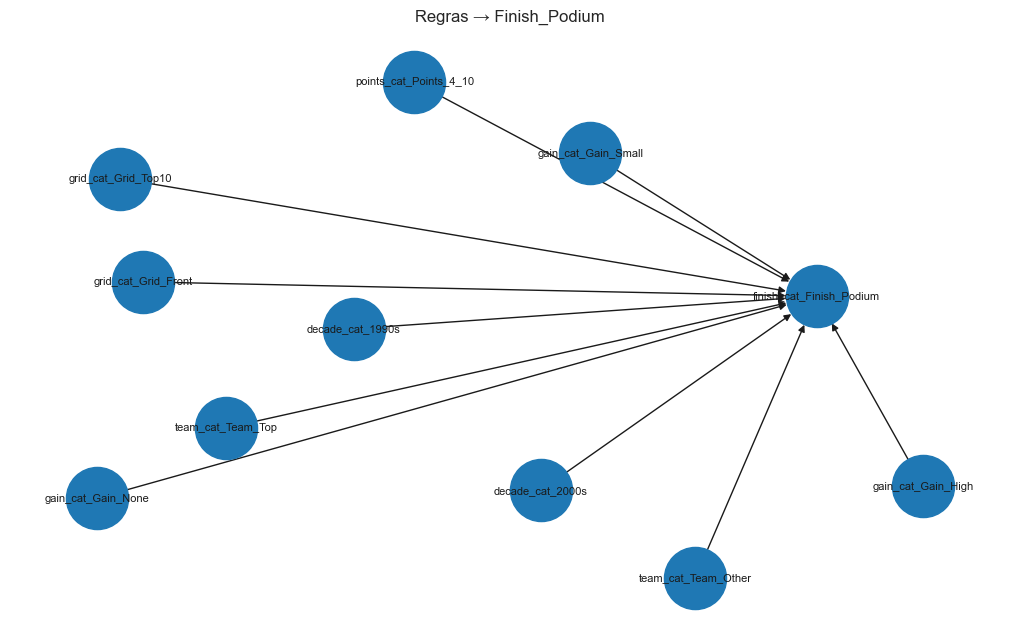

In [ ]:
# Visualizar as regras como um grafo direcionado
G = nx.DiGraph()

for _, r in rules.iterrows():
    if "finish_cat_Finish_Podium" in r["consequents"]:
        for a in r["antecedents"]:
            G.add_edge(a, "finish_cat_Finish_Podium")

pos = nx.spring_layout(G, seed=42)

plt.figure(figsize=(10, 6))
nx.draw(G, pos, with_labels=True, node_size=2000, font_size=8, arrows=True)
plt.title("Regras → Finish_Podium")
plt.show()

#### Regras de Finish_OutsideTop10 como consequente

In [72]:
# Consequente = fora do Top10
rules_outside = rules[
    rules["consequents"].astype(str).str.contains("finish_cat_Finish_OutsideTop10")
].copy()

# Filtrar: antecedente tem de conter "partir atrás" + "equipa other"
wanted = {"grid_cat_Grid_Back", "team_cat_Team_Other"}

rules_outside = rules_outside[
    rules_outside["antecedents"].apply(lambda s: wanted.issubset(set(s)))
].copy()

# Ordenar pelas regras mais interessantes
rules_outside = rules_outside.sort_values(
    by=["lift", "confidence"],
    ascending=False
)

print("Regras com Grid_Back + Team_Other = Finish_OutsideTop10:", rules_outside.shape[0])
rules_outside.head(5)

Regras com Grid_Back + Team_Other = Finish_OutsideTop10: 25


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
828,"(gain_cat_Gain_Loss, team_cat_Team_Other, grid...","(points_cat_Points_0, finish_cat_Finish_Outsid...",0.051562,0.585860,0.051562,1.0,1.706892,1.0,0.021354,inf,0.436655,0.088011,1.0,0.544006
838,"(team_cat_Team_Other, grid_cat_Grid_Back, gain...","(points_cat_Points_0, finish_cat_Finish_Outsid...",0.063296,0.585860,0.063296,1.0,1.706892,1.0,0.026214,inf,0.442125,0.108040,1.0,0.554020
348,"(gain_cat_Gain_Loss, team_cat_Team_Other, grid...",(finish_cat_Finish_OutsideTop10),0.051562,0.586533,0.051562,1.0,1.704933,1.0,0.021319,inf,0.435945,0.087911,1.0,0.543955
357,"(team_cat_Team_Other, grid_cat_Grid_Back, gain...",(finish_cat_Finish_OutsideTop10),0.063296,0.586533,0.063296,1.0,1.704933,1.0,0.026171,inf,0.441406,0.107916,1.0,0.553958
825,"(points_cat_Points_0, gain_cat_Gain_Loss, team...",(finish_cat_Finish_OutsideTop10),0.051562,0.586533,0.051562,1.0,1.704933,1.0,0.021319,inf,0.435945,0.087911,1.0,0.543955


#### Digrado de Finish_OutsideTop10 como consequente

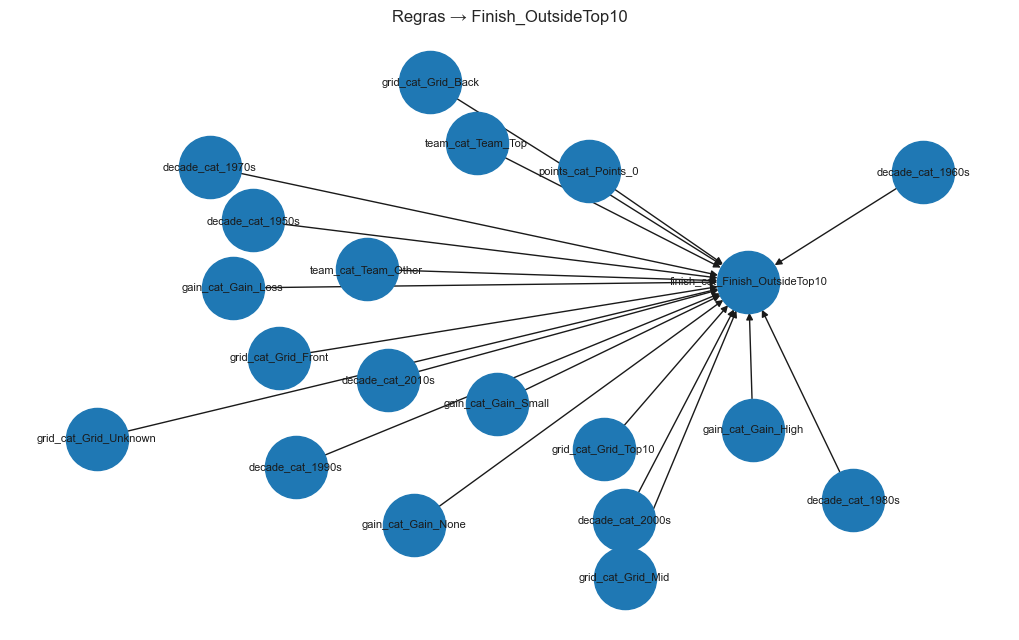

In [ ]:
# Visualizar as regras como um grafo direcionado
G = nx.DiGraph()

for _, r in rules.iterrows():
    if "finish_cat_Finish_OutsideTop10" in r["consequents"]:
        for a in r["antecedents"]:
            G.add_edge(a, "finish_cat_Finish_OutsideTop10")

pos = nx.spring_layout(G, seed=42)

plt.figure(figsize=(10, 6))
nx.draw(G, pos, with_labels=True, node_size=2000, font_size=8, arrows=True)
plt.title("Regras → Finish_OutsideTop10")
plt.show()

#### Formatação de algumas regras formatadas

In [74]:
def format_rule(row):
    antecedent = ", ".join(sorted(list(row["antecedents"])))
    consequent = ", ".join(sorted(list(row["consequents"])))
    return f"{antecedent}  ==>  {consequent}  | support={row['support']:.3f}, confidence={row['confidence']:.3f}, lift={row['lift']:.3f}"

for idx, row in rules_outside.head(5).iterrows():
    print(format_rule(row))


gain_cat_Gain_Loss, grid_cat_Grid_Back, team_cat_Team_Other  ==>  finish_cat_Finish_OutsideTop10, points_cat_Points_0  | support=0.052, confidence=1.000, lift=1.707
gain_cat_Gain_Small, grid_cat_Grid_Back, team_cat_Team_Other  ==>  finish_cat_Finish_OutsideTop10, points_cat_Points_0  | support=0.063, confidence=1.000, lift=1.707
gain_cat_Gain_Loss, grid_cat_Grid_Back, team_cat_Team_Other  ==>  finish_cat_Finish_OutsideTop10  | support=0.052, confidence=1.000, lift=1.705
gain_cat_Gain_Small, grid_cat_Grid_Back, team_cat_Team_Other  ==>  finish_cat_Finish_OutsideTop10  | support=0.063, confidence=1.000, lift=1.705
gain_cat_Gain_Loss, grid_cat_Grid_Back, points_cat_Points_0, team_cat_Team_Other  ==>  finish_cat_Finish_OutsideTop10  | support=0.052, confidence=1.000, lift=1.705


## 7. Conclusão — Association Rules (Apriori)

### 7.1. Resultados 

Neste notebook, cada registo piloto–corrida foi tratado como uma transação, composta por itens categorizados. A partir destas transações, aplicou-se o algoritmo Apriori para extrair conjuntos frequentes de itens e gerar regras de associação, avaliadas com métricas como **support**, **confidence** e **lift**.

**Resultados globais:**
- Número de transações (corridas): **3 777**
- Número de itens diferentes: **24**
- Nº de regras com consequente `Finish_Podium`: **25**
- Nº de regras com consequente `Finish_OutsideTop10`: **25**

Isto mostra que o dataset é suficientemente grande para identificar padrões repetidos, mantendo um conjunto de itens controlado, o que facilita a interpretação das regras obtidas.

---

### 7.2. Padrões fortes encontrados  

#### 7.2.1. Equipa de topo + partir na frente (e manter posição) está fortemente associado a pódio  
O Apriori identificou regras muito consistentes que combinam equipas de topo e posições de partida na frente da grelha. Um exemplo particularmente forte foi:

- `{grid_cat_Grid_Front, team_cat_Team_Top, gain_cat_Gain_None} ⇒ {finish_cat_Finish_Podium}`
  - support ≈ **0.025**
  - confidence = **1.000**
  - lift ≈ **8.06**

**Interpretação:** 
No subconjunto coberto pela regra, sempre que um piloto de uma equipa de topo parte na frente e não perde posições durante a corrida, termina no pódio. O **lift 8** indica que esta associação torna o pódio cerca de 8 vezes mais provável do que no comportamento geral do dataset.

---

#### 7.2.2. Partir na frente + não perder posições também é um padrão forte para pódio  
Mesmo sem considerar explicitamente o tipo de equipa, existe uma regra “base” muito forte:

- `{grid_cat_Grid_Front, gain_cat_Gain_None} ⇒ {finish_cat_Finish_Podium}`
  - support = **0.031**
  - confidence = **1.000**
  - lift = **8.060**

**Interpretação:** 
Em **3.1%** das corridas ocorreu a combinação partir na frente + manter posição = pódio. Sempre que um piloto parte na frente e não perde posições, acaba no pódio. Novamente, o **lift 8** confirma uma associação muito forte.

---

#### 7.2.3. Equipa fraca + partir atrás está associado a terminar fora do Top 10  
Do lado oposto, o algoritmo encontrou padrões consistentes que caracterizam corridas de menor sucesso:

- `{gain_cat_Gain_Loss, grid_cat_Grid_Back, team_cat_Team_Other} ⇒ {finish_cat_Finish_OutsideTop10}`
  - support = **0.052**
  - confidence = **1.000**
  - lift ≈ **1.705**

- `{gain_cat_Gain_Small, grid_cat_Grid_Back, team_cat_Team_Other} ⇒ {finish_cat_Finish_OutsideTop10}`
  - support = **0.063**
  - confidence = **1.000**
  - lift ≈ **1.705**

**Interpretação:** 
Quando um piloto parte atrás e pertence a uma equipa classificada como **Team_Other**, é frequente terminar fora do Top 10. O lift  mostra que esta situação aumenta claramente a probabilidade desse resultado, embora com menor força do que as regras associadas a pódios.

---

### 7.3. Conclusão final 

Com o algoritmo **Apriori**, foi possível extrair regras claras e interpretáveis que explicam padrões históricos em corridas de Fórmula 1:

Estas regras complementam os notebooks anteriores: enquanto o **Notebook 01** se foca em **prever** pódio e o **Notebook 02** em **agrupar perfis**, este **Notebook 03** contribui para **explicar** os resultados através de padrões frequentes suportados por métricas objetivas (support, confidence e lift).
